<a href="https://colab.research.google.com/github/shakira-anadella/dataset_ML/blob/main/UAS_ML_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Understanding

Import Library & Load Dataset

Pada tahap ini, dilakukan impor berbagai pustaka yang dibutuhkan untuk menjalankan proses clustering, seperti:

- `pandas` untuk manipulasi data,
- `numpy` untuk operasi numerik,
- `matplotlib.pyplot` dan `seaborn` untuk visualisasi data,
- `sklearn.cluster.KMeans` untuk algoritma K-Means,
- serta pustaka lain jika diperlukan untuk preprocessing atau evaluasi.

Dataset dibaca menggunakan `pandas.read_csv()` dari file yang tersedia. Dataset ini akan digunakan sebagai input untuk proses clustering. Pemeriksaan awal terhadap dataset dilakukan untuk melihat beberapa baris pertama serta informasi umum mengenai data, seperti jumlah kolom dan tipe data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


url = "https://raw.githubusercontent.com/shakira-anadella/dataset_ML/refs/heads/main/top_insta_influencers_data.csv"
df = pd.read_csv(url)

### 2. Data Preprocessing

Sebelum melakukan clustering, data perlu dibersihkan dan disesuaikan. Beberapa langkah preprocessing umum yang dilakukan:

- Menghapus nilai yang tidak relevan atau duplikat.
- Mengisi atau menghapus data yang kosong (missing values).
- Melakukan konversi data ke tipe numerik jika diperlukan.
- Normalisasi atau standarisasi data untuk menghindari bias karena skala fitur yang berbeda.
- Mengubah nilai string (seperti "10k", "5M", "30%") menjadi angka murni jika diperlukan.

Preprocessing ini penting agar algoritma K-Means dapat bekerja dengan baik.

In [ ]:
# Data Preprocessing
# Fungsi untuk mengubah shorthand (k, m, b, %) ke angka
def parse_shorthand(val):
    if isinstance(val, str):
        v = val.strip().lower()
        if v.endswith('k'):
            return float(v[:-1]) * 1_000
        elif v.endswith('m'):
            return float(v[:-1]) * 1_000_000
        elif v.endswith('b'):
            return float(v[:-1]) * 1_000_000_000
        elif v.endswith('%'):
            return float(v[:-1]) / 100
        else:
            try:
                return float(v.replace(',', ''))
            except:
                return np.nan
    return val

# Konversi kolom-kolom penting
cols_to_convert = [
    'posts', 'followers', 'avg_likes',
    'total_likes', 'new_post_avg_like', '60_day_eng_rate'
]
for col in cols_to_convert:
    df[col] = df[col].apply(parse_shorthand)

# Hilangkan baris dengan nilai kosong di kolom-kolom yang penting
important = ['influence_score'] + cols_to_convert
df_clean = df.dropna(subset=important)

# Reset index agar rapi
df_clean = df_clean.reset_index(drop=True)

# Tampilkan info dan 5 baris pertama
print("Data setelah cleaning:")
print(df_clean[important].info())
print(df_clean[important].head())

Data setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   influence_score    199 non-null    int64  
 1   posts              199 non-null    float64
 2   followers          199 non-null    float64
 3   avg_likes          199 non-null    float64
 4   total_likes        199 non-null    float64
 5   new_post_avg_like  199 non-null    float64
 6   60_day_eng_rate    199 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 11.0 KB
None
   influence_score   posts    followers  avg_likes   total_likes  \
0               92  3300.0  475800000.0  8700000.0  2.900000e+10   
1               91  6900.0  366200000.0  8300000.0  5.740000e+10   
2               90   890.0  357300000.0  6800000.0  6.000000e+09   
3               93  1800.0  342700000.0  6200000.0  1.150000e+10   
4               91  6800.0  334100000.0  1900

### 3. Exploratory Data Analysis (EDA)

Pada tahap ini dilakukan eksplorasi terhadap data untuk memahami pola, distribusi, dan hubungan antar fitur.

Beberapa hal yang dilakukan:

- Menampilkan statistik deskriptif untuk melihat ringkasan data numerik.
- Membuat heatmap korelasi untuk mengetahui hubungan antar fitur, misalnya apakah jumlah followers berkorelasi dengan jumlah like.
- Menampilkan histogram distribusi fitur untuk melihat penyebaran nilai dalam setiap kolom.

Langkah ini penting agar kita memiliki gambaran awal sebelum masuk ke tahap clustering.


Statistik Deskriptif:


,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
count,199.000000,199.000000,199.000000,1.990000e+02,1.990000e+02,199.000000,1.990000e+02,1.990000e+02
mean,100.160804,81.814070,3516.884422,7.761256e+07,1.741310e+06,0.019020,1.214204e+06,3.670465e+09
std,57.825532,8.900153,3476.215047,7.381699e+07,2.100856e+06,0.033297,1.861019e+06,5.573215e+09
min,1.000000,22.000000,10.000000,3.280000e+07,6.510000e+04,0.000100,0.000000e+00,1.830000e+07
25%,50.500000,80.000000,950.000000,4.005000e+07,5.031000e+05,0.004100,1.983500e+05,9.937000e+08
50%,100.000000,84.000000,2100.000000,5.020000e+07,1.100000e+06,0.008800,5.327000e+05,2.000000e+09
75%,149.500000,86.000000,5050.000000,6.890000e+07,2.100000e+06,0.020350,1.350000e+06,4.000000e+09
max,200.000000,93.000000,17500.000000,4.758000e+08,1.540000e+07,0.264100,1.260000e+07,5.740000e+10


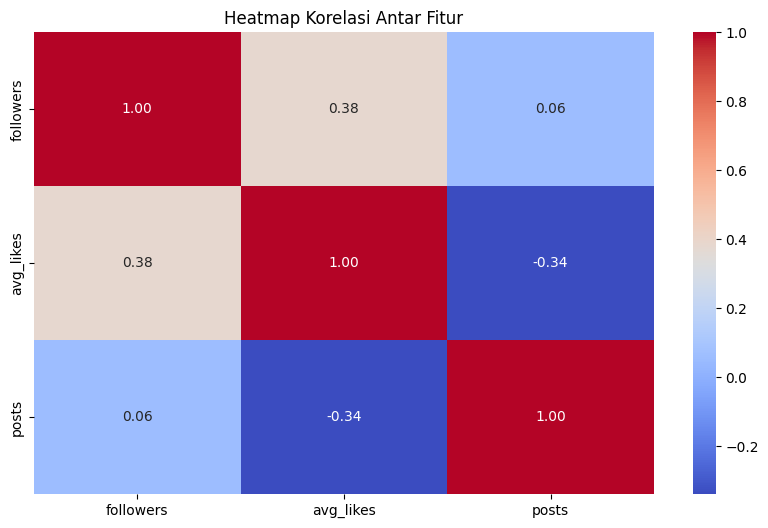

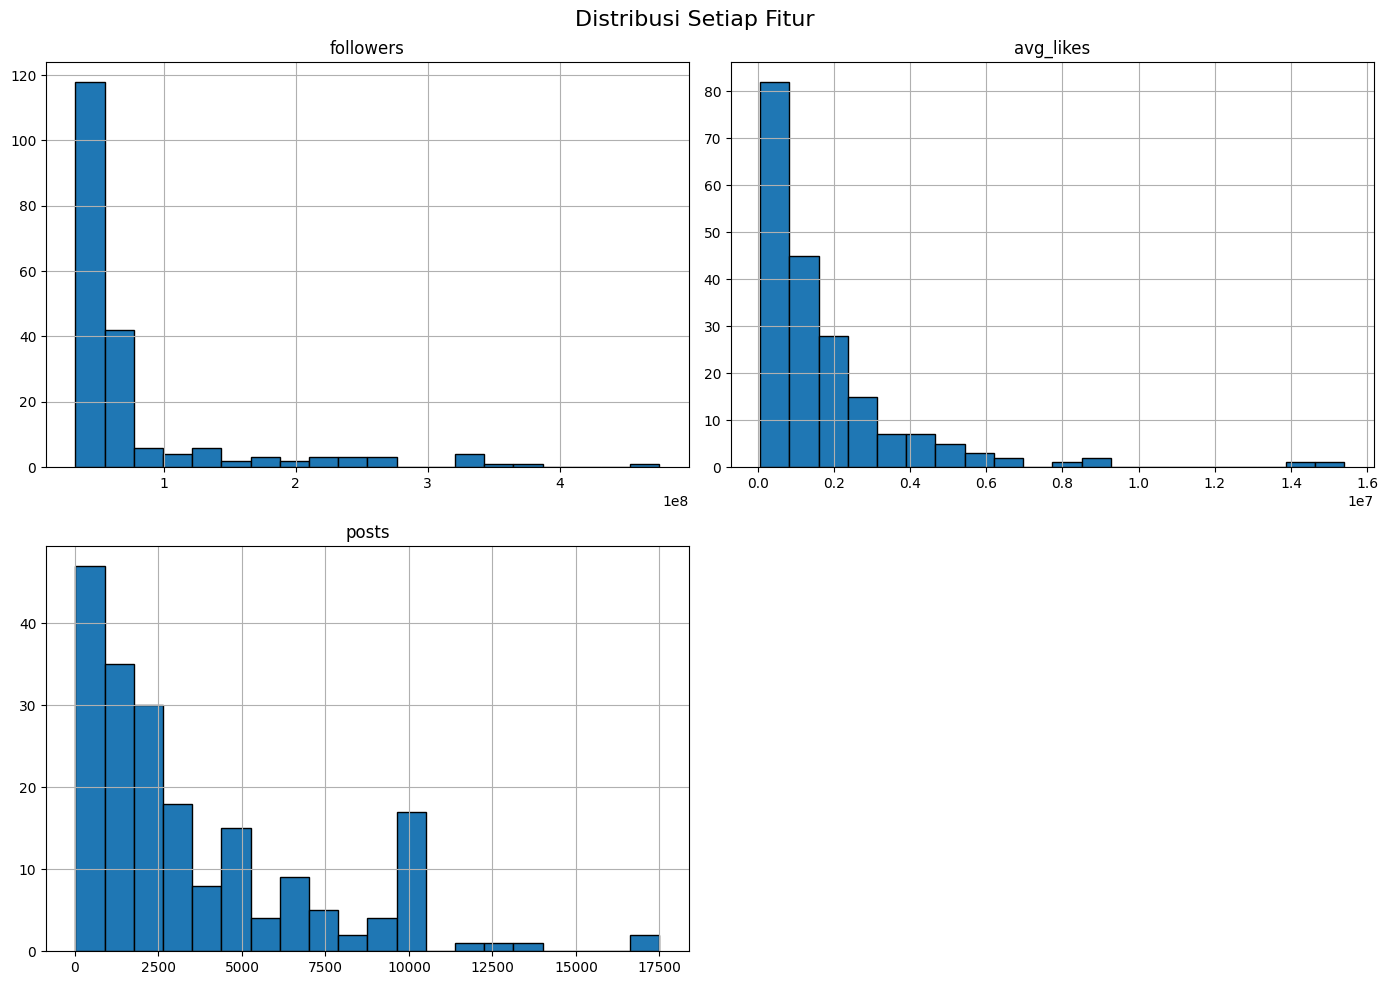

In [ ]:
# Statistik deskriptif
print("Statistik Deskriptif:")
display(df_clean.describe())

# Cek korelasi antar fitur
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

# Distribusi masing-masing fitur
df_clean[features].hist(bins=20, figsize=(14, 10), edgecolor='black')
plt.suptitle("Distribusi Setiap Fitur", fontsize=16)
plt.tight_layout()
plt.show()


### 4. Menentukan Jumlah Cluster dengan Elbow Method

Sebelum melakukan clustering dengan algoritma K-Means, kita perlu menentukan jumlah klaster (`k`) yang optimal. Salah satu cara yang umum digunakan adalah **Elbow Method**.

Langkah-langkah yang dilakukan:

1. Menstandarisasi data menggunakan Z-score normalization agar semua fitur berada dalam skala yang sama.
2. Menjalankan K-Means untuk berbagai nilai `k` (dari 1 hingga 10).
3. Menyimpan nilai **inertia** (jumlah kuadrat jarak titik ke pusat klasternya masing-masing) untuk setiap `k`.
4. Memvisualisasikan hubungan antara `k` dan inertia dalam bentuk kurva.
5. Titik "tekukan" pada kurva (elbow point) menunjukkan jumlah klaster optimal — yaitu saat penurunan inertia mulai melambat secara signifikan.

Visualisasi Elbow Curve membantu kita memilih `k` secara intuitif berdasarkan bentuk grafik.


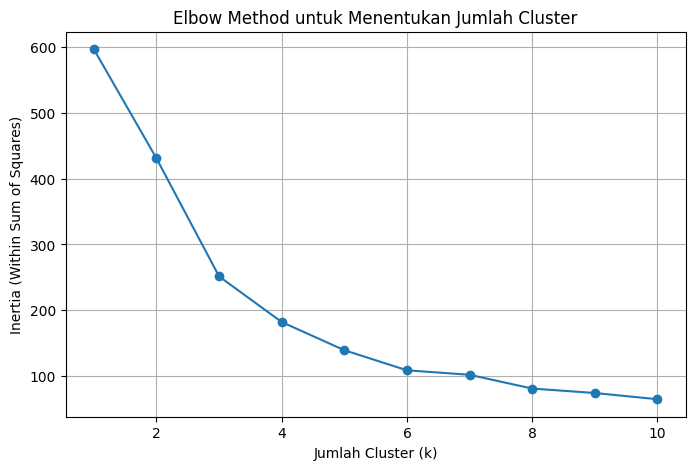

In [ ]:
# Pilih hanya 3 fitur: followers, avg_likes, dan posts
features = ['followers', 'avg_likes', 'posts']
X = df_clean[features]

# Standarisasi (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method: coba jumlah cluster 1–10
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Within Sum of Squares)')
plt.grid(True)
plt.show()


### 5. Visualisasi Hasil Clustering dengan PCA

Setelah model K-Means dijalankan dan data dikelompokkan ke dalam klaster, tahap selanjutnya adalah memvisualisasikan hasil clustering. Karena data memiliki banyak fitur (dimensi), dilakukan reduksi dimensi menggunakan **PCA (Principal Component Analysis)** agar bisa divisualisasikan dalam ruang 2 dimensi (2D).

Langkah-langkah:

1. Menjalankan KMeans dengan `k=3` dan menyimpan label klaster untuk setiap data.
2. Mereduksi data hasil standarisasi ke dua komponen utama menggunakan PCA.
3. Membuat plot 2D untuk memvisualisasikan sebaran data berdasarkan hasil klastering.

Visualisasi ini membantu untuk melihat sejauh mana pemisahan antar klaster yang terbentuk, meskipun tidak menggambarkan semua dimensi asli data.


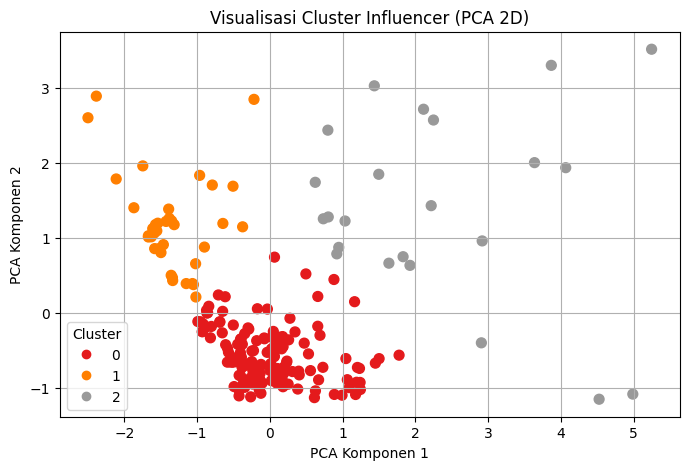

In [ ]:
# Jalankan K-Means dengan k = 3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Lakukan PCA untuk mereduksi dimensi ke 2D (agar bisa divisualisasikan)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualisasi cluster
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['cluster'], cmap='Set1', s=50)
plt.title("Visualisasi Cluster Influencer (PCA 2D)")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


### 6. Interpretasi dan Analisis Hasil Clustering

Setelah data dikelompokkan ke dalam klaster, dilakukan analisis terhadap masing-masing klaster untuk memahami karakteristiknya.

Langkah-langkah:

- Menghitung rata-rata setiap fitur dalam masing-masing klaster.
- Memberikan label interpretatif berdasarkan ciri khas tiap klaster, seperti:
  - **Micro Influencer**: followers sedikit, engagement rate tinggi.
  - **Mid Influencer**: followers sedang, cukup stabil.
  - **Mega Influencer**: followers sangat banyak, tetapi engagement bisa bervariasi.
- Menampilkan visualisasi distribusi followers untuk membandingkan antar klaster.
- Menyimpan hasil clustering lengkap ke file CSV untuk analisis lanjutan atau pelaporan.

Tahap ini penting untuk menghubungkan hasil model dengan konteks nyata di dunia bisnis atau sosial media.


            followers     avg_likes        posts
cluster                                         
0        5.436159e+07  1.574564e+06  1888.115942
1        6.356842e+07  3.842579e+05  9568.421053
2        2.403217e+08  4.983870e+06  3291.304348


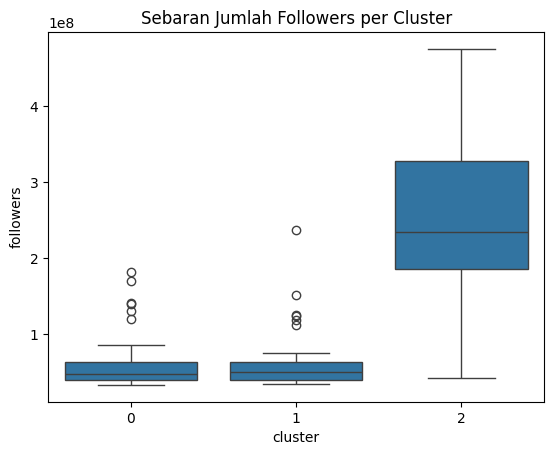

            followers     avg_likes        posts
cluster                                         
0        5.436159e+07  1.574564e+06  1888.115942
1        6.356842e+07  3.842579e+05  9568.421053
2        2.403217e+08  4.983870e+06  3291.304348


In [ ]:
#Analisis Hasil CLustering

# Rata-rata nilai fitur pada masing-masing cluster
cluster_summary = df_clean.groupby('cluster')[features].mean()
print(cluster_summary)

# Contoh pengkategorian manual berdasarkan observasi
cluster_names = {
    0: "Micro Influencer",
    1: "Mid Influencer",
    2: "Mega Influencer"
}
df_clean['cluster_label'] = df_clean['cluster'].map(cluster_names)

# sebaran followers per cluster:
sns.boxplot(data=df_clean, x="cluster", y="followers")
plt.title("Sebaran Jumlah Followers per Cluster")
plt.show()

# Tambahkan label cluster
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Tampilkan rata-rata per cluster
cluster_summary = df_clean.groupby('cluster')[['followers', 'avg_likes', 'posts']].mean()
print(cluster_summary)

# Simpan hasil clustering ke file CSV baru
df_clean.to_csv("hasil_clustering_influencer.csv", index=False)

### 7. Menyimpan Model (Export Model)

Setelah model K-Means dan proses preprocessing selesai dilakukan, model disimpan ke dalam file `.pkl` menggunakan library `joblib`.

Model yang disimpan:

- `model.pkl`: berisi model K-Means yang telah dilatih.
- `scaler.pkl`: berisi objek `StandardScaler` yang digunakan untuk normalisasi data.

Model ini dapat digunakan kembali untuk memprediksi klaster data baru tanpa perlu melatih ulang, sehingga efisien untuk digunakan dalam sistem produksi atau aplikasi lanjutan.


In [ ]:
joblib.dump(kmeans, 'model.pkl')     # Model KMeans
joblib.dump(scaler, 'scaler.pkl')    # StandardScaler

['scaler.pkl']

In [ ]:
from google.colab import files

files.download('model.pkl')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>